# Load Data from Google Drive

In [30]:
# Reading a Excel File from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
import pandas as pd
df = pd.read_excel('gdrive/My Drive/NIDA_CRM_Homework/Homework07/Online_Retail.xlsx')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [32]:
missing = df.isnull().sum()
print(missing)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


# Find unique product

In [33]:
df.Description.unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'lost',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [34]:
len(df.Description.unique())

4224

# Remove Unknown Product Row

In [35]:
df = df.dropna(subset=['Description'])
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


# Counting number of buying product


In [36]:
df_for_top10_Description=df['Description'].value_counts().head(10)
df_for_top10_Description

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
ASSORTED COLOUR BIRD ORNAMENT         1501
SET OF 3 CAKE TINS PANTRY DESIGN      1473
PACK OF 72 RETROSPOT CAKE CASES       1385
LUNCH BAG  BLACK SKULL.               1350
NATURAL SLATE HEART CHALKBOARD        1280
Name: Description, dtype: int64

# Top Ten Product

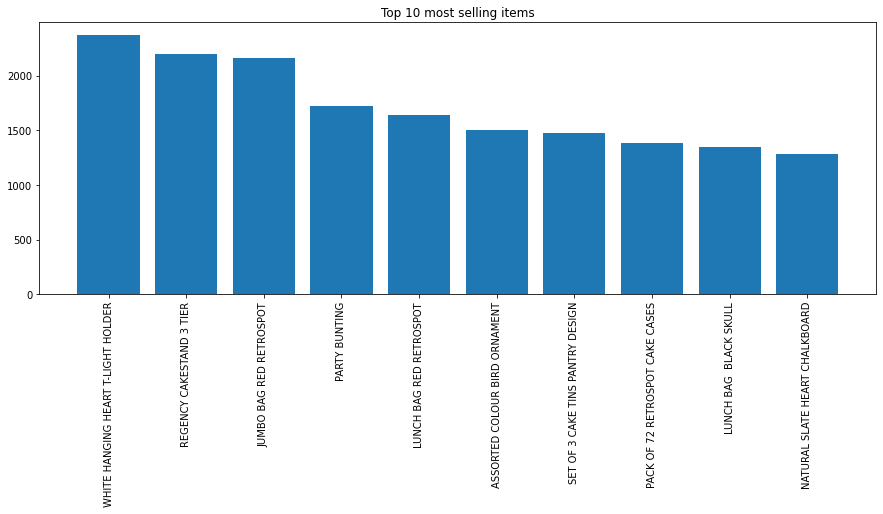

In [38]:
import numpy as np
import matplotlib.pyplot as plt

Item_array= np.arange(len(df_for_top10_Description))

plt.figure(figsize=(15,5))
Items_name=['WHITE HANGING HEART T-LIGHT HOLDER',
            'REGENCY CAKESTAND 3 TIER',
            'JUMBO BAG RED RETROSPOT',
            'PARTY BUNTING',
            'LUNCH BAG RED RETROSPOT',
            'ASSORTED COLOUR BIRD ORNAMENT',
            'SET OF 3 CAKE TINS PANTRY DESIGN',
            'PACK OF 72 RETROSPOT CAKE CASES',
            'LUNCH BAG  BLACK SKULL',
            'NATURAL SLATE HEART CHALKBOARD']
plt.bar(Item_array,df_for_top10_Description.iloc[:])
plt.xticks(Item_array,Items_name, rotation=90)
plt.title('Top 10 most selling items')
plt.show()


In [39]:
hot_encoded_df=df.groupby(['InvoiceNo','Description'])['Description'].count().unstack().reset_index().fillna(0).set_index('InvoiceNo')
hot_encoded_df.head(5)

Description,20713,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,...,sold as set on dotcom,sold as set on dotcom and amazon,sold as set/6 by dotcom,sold in set?,sold with wrong barcode,stock check,stock creditted wrongly,taig adjust,taig adjust no stock,temp adjustment,test,throw away,thrown away,thrown away-can't sell,thrown away-can't sell.,to push order througha s stock was,water damage,water damaged,website fixed,wet,wet boxes,wet damaged,wet pallet,wet rusty,wet/rusty,wet?,wrong barcode,wrong barcode (22467),wrong code,wrong code?,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
hot_encoded_df = hot_encoded_df.applymap(encode_units)

In [41]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(hot_encoded_df, min_support=0.01, use_colnames=True)

In [42]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(6 RIBBONS RUSTIC CHARM),(WHITE HANGING HEART T-LIGHT HOLDER),0.039311,0.094167,0.010513,0.267430,2.839960,0.006811,1.236514
1,(WHITE HANGING HEART T-LIGHT HOLDER),(6 RIBBONS RUSTIC CHARM),0.094167,0.039311,0.010513,0.111642,2.839960,0.006811,1.081421
2,(PAPER CHAIN KIT 50'S CHRISTMAS ),(60 CAKE CASES VINTAGE CHRISTMAS),0.047861,0.025444,0.011167,0.233333,9.170525,0.009950,1.271160
3,(60 CAKE CASES VINTAGE CHRISTMAS),(PAPER CHAIN KIT 50'S CHRISTMAS ),0.025444,0.047861,0.011167,0.438907,9.170525,0.009950,1.696936
4,(PAPER CHAIN KIT VINTAGE CHRISTMAS),(60 CAKE CASES VINTAGE CHRISTMAS),0.034034,0.025444,0.010349,0.304087,11.951285,0.009483,1.400398
5,(60 CAKE CASES VINTAGE CHRISTMAS),(PAPER CHAIN KIT VINTAGE CHRISTMAS),0.025444,0.034034,0.010349,0.406752,11.951285,0.009483,1.628268
6,(60 CAKE CASES VINTAGE CHRISTMAS),(SET OF 20 VINTAGE CHRISTMAS NAPKINS),0.025444,0.025239,0.011167,0.438907,17.389813,0.010525,1.737253
7,(SET OF 20 VINTAGE CHRISTMAS NAPKINS),(60 CAKE CASES VINTAGE CHRISTMAS),0.025239,0.025444,0.011167,0.442464,17.389813,0.010525,1.747968
8,(72 SWEETHEART FAIRY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.025321,0.034198,0.011372,0.449111,13.132750,0.010506,1.753172
9,(60 TEATIME FAIRY CAKE CASES),(72 SWEETHEART FAIRY CAKE CASES),0.034198,0.025321,0.011372,0.332536,13.132750,0.010506,1.460272


# Filter Association Rules with Confidential >= 0.8 and Lift >= 10

In [45]:
rules2 = rules[ (rules['lift'] >= 10) &
       (rules['confidence'] >= 0.8) ]

# Ploting Association Rules

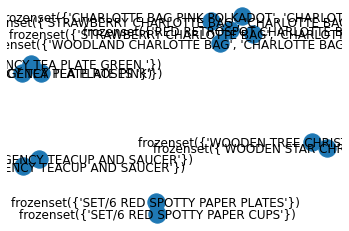

In [47]:
import matplotlib.pyplot as plt
import networkx as nx

fig, ax=plt.subplots()
GA=nx.from_pandas_edgelist(rules2[:10],source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()

In [48]:
item_item_matrix = pd.DataFrame(index=hot_encoded_df.columns,columns=hot_encoded_df.columns)

In [50]:
from scipy.spatial.distance import cosine

for i in range(0,len(item_item_matrix.columns)) :
    # Loop through the columns for each column
    for j in range(0,len(item_item_matrix.columns)) :
      # Fill in placeholder with cosine similarities
      item_item_matrix.iloc[i,j] = 1 -cosine(hot_encoded_df.iloc[:,i],hot_encoded_df.iloc[:,j])

In [51]:
links = item_item_matrix.rename_axis('related item', 
                                     axis='columns').stack().reset_index()
links.columns = ['item', 'related item','value']

In [52]:
links_filtered=links.loc[ (links['value'] > 0.1) & 
                         (links['item'] != links['related item']) ]

# Plotting Product Recommendation

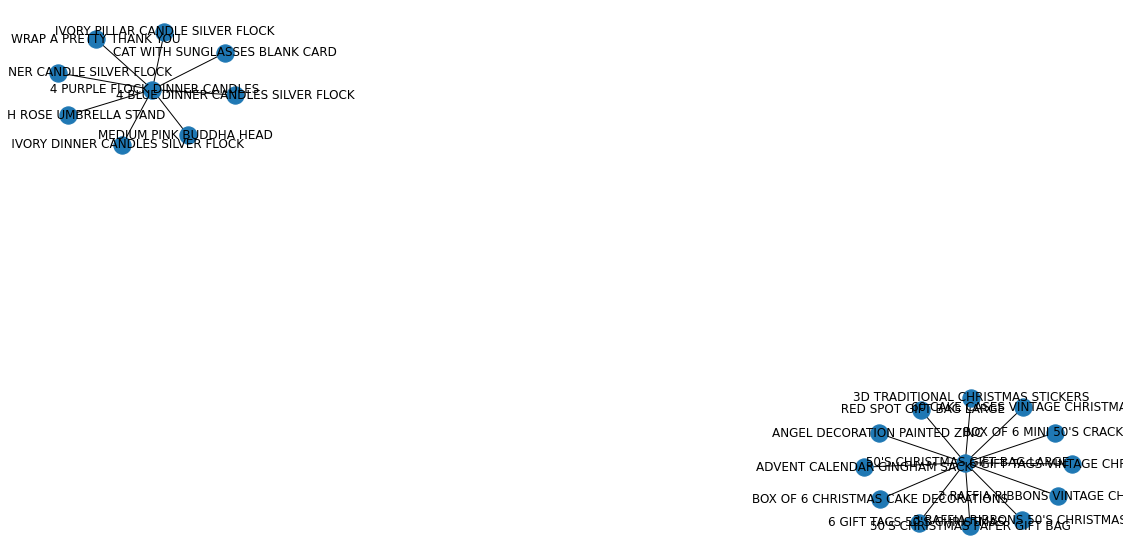

In [56]:
import matplotlib.pyplot as plt
import networkx as nx

fig, ax=plt.subplots(figsize=(20, 10))
GA=nx.from_pandas_edgelist(links_filtered[:20],source='item',target='related item')
nx.draw(GA,with_labels=True)
plt.show()